## algo des fourmis fonctionnel V2 : 

## Implementation de l'algorithme

In [129]:
import numpy as np
import random as rand
import math as m
import networkx as nx
import matplotlib.pyplot as plt
import time
import threading as th
from concurrent.futures import ThreadPoolExecutor

In [130]:
def generate_random_symmetrical_boolean_graph(n):
    while True:
        A = np.triu(np.random.randint(0, 2, (n, n)), 1)
        A += A.T
        if np.all(A.sum(axis=0)):
            return A

In [131]:
def generate_random_collect_points(cities):
    return np.random.randint(0, 2, cities)

In [132]:
def generate_random_delivery_requests(cities, collect_points):
    deliveries = set()
    for i, collect in enumerate(collect_points):
        if collect:
            number_of_drop_points = rand.randint(1, cities)
            deliveries.update((i, rand.randint(0, cities - 1)) for _ in range(number_of_drop_points))
    return sorted(deliveries)

In [133]:
def initialize_pheromones(A, initial_pheromone):
    return np.multiply(A, np.full(A.shape, initial_pheromone))

In [134]:
def update_pheromones(pheromones, paths, deliveries, phi, Temp, amplitude, offset, frequency):
    for path, cost in paths:
        if cost == float('inf'):
            continue
        delivery_count = sum(1 for city in path if any(city in deliveries for obj in deliveries))
        for t, (i, j) in enumerate(zip(path[:-1], path[1:])):
            pheromones[i][j] += (Q / cost) * (delivery_count / len(deliveries)) * (1.0 / C(i, j, t, phi, Temp, amplitude, offset, frequency))
    pheromones *= (1 - RHO)
    return pheromones

In [144]:
def C(i, j, t, phi, Temp, amplitude, offset, frequency):
    return max(1, round((amplitude * m.sin(frequency * t + phi[i][j]) + offset) * Temp[i][j], 4)) if i != j else float('inf')

In [145]:
def construct_path(graph, pheromones, deliveries, start_city, phi, Temp, amplitude, offset, frequency):
    n = len(graph)
    path = [start_city]
    cost = 0
    visited = set([start_city])
    collected_items = set()
    delivered_items = set()
    pending_deliveries = set(deliveries)

    t = 0  # Initialize time for dynamic cost calculation
    all_collect_points = set(i for i, _ in deliveries)

    while pending_deliveries:
        current = path[-1]
        choices = [i for i in range(n) if graph[current][i] > 0 and i != current]

#        filtered_choices = []
#        for i in choices:
#            dynamic_cost = C(current, i, t, phi, Temp, amplitude, offset, frequency)
#            if dynamic_cost != float('inf'):
#                filtered_choices.append(i)

#        if not filtered_choices:
#            filtered_choices = [i for i in range(n) if graph[current][i] > 0 and i != current]

        probabilities = np.array([pheromones[current][i] ** ALPHA * (1.0 / C(current, i, t, phi, Temp, amplitude, offset, frequency)) ** BETA for i in choices])
        total = probabilities.sum()
        if total == 0:
            next_city = start_city
        else:
            probabilities /= total
            next_city = rand.choices(choices, weights=probabilities, k=1)[0]

        if next_city == start_city:
            break

        path.append(next_city)
        visited.add(next_city)
        cost += C(current, next_city, t, phi, Temp, amplitude, offset, frequency)

        # Check and update collections
        if next_city in all_collect_points:
            collected_items.add(next_city)

        # Check and update deliveries
        for item, location in list(pending_deliveries):
            if next_city == location:
                delivered_items.add((item, location))
                pending_deliveries.remove((item, location))
                if next_city == item:
                    collected_items.add(item)

        t += 1
        
    # Ensure all deliveries are met, revisiting cities if necessary
    while pending_deliveries:
        current = path[-1]
        for item, location in list(pending_deliveries):
            if item not in collected_items:
                path.append(item)
                cost += C(path[-2], item, len(path)-2, phi, Temp, amplitude, offset, frequency)
                collected_items.add(item)
            path.append(location)
            cost += C(path[-2], location, len(path)-2, phi, Temp, amplitude, offset, frequency)
            delivered_items.add((item, location))
            pending_deliveries.remove((item, location))

    if len(path) > 1 and path[-1] == path[-2]:
        path.pop()

    return path, cost

In [146]:
def check_delivery_done(R, D):
    return all(item in D for item in R)


In [147]:
def find_backup_path(graph, deliveries, start_city, phi, Temp, amplitude, offset, frequency):
    path = [start_city]
    collected_items = set()
    cost = 0
    for item, location in deliveries:
        if item not in collected_items:
            if path[-1] != item:
                path.append(item)
                cost += C(path[-2], item, len(path)-2, phi, Temp, amplitude, offset, frequency)
            collected_items.add(item)
        if item != location:
            path.append(location)
            cost += C(path[-2], location, len(path)-2, phi, Temp, amplitude, offset, frequency)
    path.append(start_city)
    cost += C(path[-2], start_city, len(path)-2, phi, Temp, amplitude, offset, frequency)
    return path, cost

In [148]:
def ant_colony_optimization(graph, deliveries, phi, Temp, amplitude, offset, frequency):
    start_time = time.time()  # Start the timer
    start_city = rand.randint(0, len(graph) - 1)
    pheromones = initialize_pheromones(graph, 0.1)
    best_path, best_cost = None, float('inf')

    for _ in range(NB_ITERATIONS):
        paths = [construct_path(graph, pheromones, deliveries, start_city, phi, Temp, amplitude, offset, frequency) for _ in range(NB_FOURMIS)]
        valid_paths = [(path, cost) for path, cost in paths if check_delivery_done(deliveries, [(i, j) for i, j in zip(path[:-1], path[1:])])]
        if valid_paths:
            path, cost = min(valid_paths, key=lambda x: x[1])
            if cost < best_cost:
                best_path, best_cost = path, cost
        update_pheromones(pheromones, valid_paths, deliveries, phi, Temp, amplitude, offset, frequency)

    if best_path is None:
        best_path, best_cost = find_backup_path(graph, deliveries, start_city, phi, Temp, amplitude, offset, frequency)

    # Correct the path if the last and the second to last cities are the same
    if len(best_path) > 1 and best_path[-1] == best_path[-2]:
        best_path = best_path[:-1]
    
    end_time = time.time()  # End the timer
    time_taken = end_time - start_time  # Calculate the time taken

    return best_path, best_cost, start_city, time_taken


In [149]:
def draw_graph_with_path_and_weights(graph, path, phi, Temp, amplitude, offset, frequency):
    G = nx.Graph()
    for i in range(len(graph)):
        for j in range(i, len(graph[i])):
            if graph[i][j] > 0:
                G.add_edge(i, j, weight=C(i, j, 0, phi, Temp, amplitude, offset, frequency))
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=700)
    path_edges = [(path[i], path[i+1]) for i in range(len(path)-1)]
    nx.draw_networkx_edges(G, pos, edgelist=path_edges, edge_color='r', width=2)
    plt.title('Graph with Path and Edge Weights')
    plt.show()


 Deliveries:
Object from city 2 need to be deliver in city: 0
Object from city 2 need to be deliver in city: 1
Object from city 2 need to be deliver in city: 2
Object from city 2 need to be deliver in city: 4
Object from city 2 need to be deliver in city: 6
Object from city 2 need to be deliver in city: 7
Object from city 2 need to be deliver in city: 9
Object from city 4 need to be deliver in city: 0
Object from city 4 need to be deliver in city: 2
Object from city 4 need to be deliver in city: 8
Object from city 6 need to be deliver in city: 2
Object from city 6 need to be deliver in city: 7
Object from city 7 need to be deliver in city: 1
Object from city 7 need to be deliver in city: 6
Object from city 7 need to be deliver in city: 9

Best path starting from city 0 : [0, 2, 0, 1, 4, 6, 7, 9, 4, 0, 2, 8, 6, 2, 7, 1, 6, 9, 0]
Cost of best path: 58.937900000000006
Time taken: 0.10101175308227539 seconds


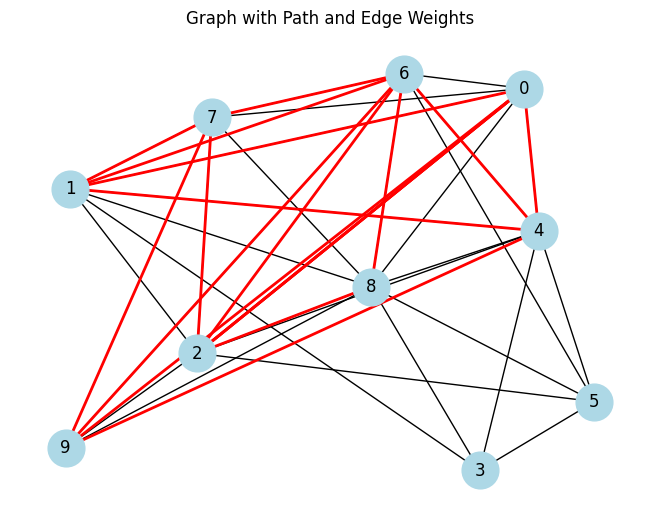

In [150]:
# Constants for the ACO algorithm
NB_FOURMIS = 10 # Number of ants
NB_ITERATIONS = 10  # Number of iterations
ALPHA = 1.0  # Influence of pheromones
BETA = 2.0  # Influence of the heuristic (inverse of the distance)
RHO = 0.5  # Pheromone evaporation rate
Q = 100  # Quantity of pheromones deposited


if __name__ == '__main__':
    n = 10
    phi = np.random.uniform(0.5, 5, (n, n))
    Temp = np.random.uniform(0, 20, (n, n))
    amplitude = 0.7
    offset = 0.3
    frequency = 0.5

    graph = generate_random_symmetrical_boolean_graph(n)
    collect_points = generate_random_collect_points(n)
    deliveries = generate_random_delivery_requests(n, collect_points)
    print("\n Deliveries:")
    for delivery in deliveries:
        print(f"Object from city {int(delivery[0])} need to be deliver in city: {int(delivery[1])}")

    best_path, best_cost, start_city, time_taken = ant_colony_optimization(graph, deliveries, phi, Temp, amplitude, offset, frequency)
    if best_path:
        print("\nBest path starting from city", start_city, ":", best_path)
        print("Cost of best path:", best_cost)
        print("Time taken:", time_taken, "seconds")
        draw_graph_with_path_and_weights(graph, best_path, phi, Temp, amplitude, offset, frequency)
    else:
        print("No valid path was found that meets all delivery requirements.")

# plan d'experience 

##  Méthodologie

 Pour évaluer les performances de notre algorithme, nous allons varier les paramètres suivants :

 - Nombre de villes (n) 
 - Amplitude du coût dynamique (amplitude) 
 - Offset du coût dynamique (offset) 
 - Fréquence du coût dynamique (frequency) 
 - Nombre de fourmis (nb_fourmis) 
 - Nombre d'itérations (nb_iterations)
 - Influence des phéromones (alpha) 
 - Influence de l'heuristique (beta) 
 - Taux d'évaporation des phéromones (rho) 
 - Quantité de phéromones déposée (q) 

## Etude du comportement des parametres 

In [202]:
from ipywidgets import IntProgress
from IPython.display import display

In [221]:
def run_test(n, amplitude, offset, frequency, nb_fourmis, nb_iterations, alpha, beta, rho, q):
    global NB_FOURMIS, NB_ITERATIONS, ALPHA, BETA, RHO, Q
    NB_FOURMIS, NB_ITERATIONS, ALPHA, BETA, RHO, Q = nb_fourmis, nb_iterations, alpha, beta, rho, q
    
    phi = np.random.uniform(0.5, 5, (n, n))
    Temp = np.random.uniform(0, 20, (n, n))

    graph = generate_random_symmetrical_boolean_graph(n)
    collect_points = generate_random_collect_points(n)
    deliveries = generate_random_delivery_requests(n, collect_points)
    best_path, best_cost, start_city, time_taken = ant_colony_optimization(graph, deliveries, phi, Temp, amplitude, offset, frequency)
    if best_path:
        print("Cost of best path:", best_cost)
        print("Time taken:", time_taken, "seconds")    
    else:
        print("No valid path was found that meets all delivery requirements.")

In [224]:
def run_test_amplitude(n, amplitude_min, amplitude_max,amplitude_step, iterations):
    average_times =[]
    worst_times = []
    best_times = []
    

    nb_tests = ((amplitude_max	- amplitude_min) / amplitude_step) * iterations
    bar = IntProgress(min=0, max=nb_tests, layout={"width" : "100%"})
    display(bar)
    for amp in range(amplitude_min, amplitude_max, amplitude_step):
        best_time = float('inf')
        worst_time = 0
        average_time = 0
        amplitude = amp/10
        for i in range(iterations): 
            print(f"\nRunning test with amplitude: {amplitude}")
        
            start = time.time()
            run_test(n, amplitude, 0.3, 0.5, 10, 10, 1.0, 2.0, 0.5, 100)
            stop = time.time()

            tps = stop - start
            if(tps > worst_time):
                worst_time = tps

            if(tps < best_time):
                best_time = tps

            average_time += tps
            
            bar.value += 1 # on met à jour la barre de progression
        
        # on met à jour les listes des temps d'exécution
        average_times.append(average_time/iterations)
        best_times.append(best_time)
        worst_times.append(worst_time)

    # on cache la barre de progression
    bar.close()
    
    # on règle l'affichage des courbes
    amplitudes = [x for x in range(amplitude_min, amplitude_max, amplitude_step)]
    plt.figure(figsize=(20,10))
    
    plt.xlabel('amplitude')
    plt.xticks(ticks=amplitudes) # valeurs affichées sur l'axe X
    plt.ylabel('temps de calcul')
    
    # on charge les données
    plt.plot(amplitudes, average_times,   label='average time')
    plt.plot(amplitudes, best_times, label='best time')
    plt.plot(amplitudes, worst_times,  label='worst time')
    
    # on affiche
    plt.legend()
    plt.show()

IntProgress(value=0, layout=Layout(width='100%'), max=40)


Running test with amplitude: 0.7
Cost of best path: 59.0804
Time taken: 0.060534000396728516 seconds

Running test with amplitude: 0.7
Cost of best path: inf
Time taken: 0.029383420944213867 seconds

Running test with amplitude: 0.7
Cost of best path: 87.25989999999999
Time taken: 0.0823218822479248 seconds

Running test with amplitude: 0.7
Cost of best path: 42.5812
Time taken: 0.022411584854125977 seconds

Running test with amplitude: 0.7
Cost of best path: 173.72149999999996
Time taken: 0.05264735221862793 seconds

Running test with amplitude: 0.7
Cost of best path: inf
Time taken: 0.07450294494628906 seconds

Running test with amplitude: 0.7
Cost of best path: inf
Time taken: 0.07684087753295898 seconds

Running test with amplitude: 0.7
Cost of best path: 51.21150000000001
Time taken: 0.06455826759338379 seconds

Running test with amplitude: 0.7
Cost of best path: 45.2006
Time taken: 0.13148903846740723 seconds

Running test with amplitude: 0.7
Cost of best path: 87.34799999999998

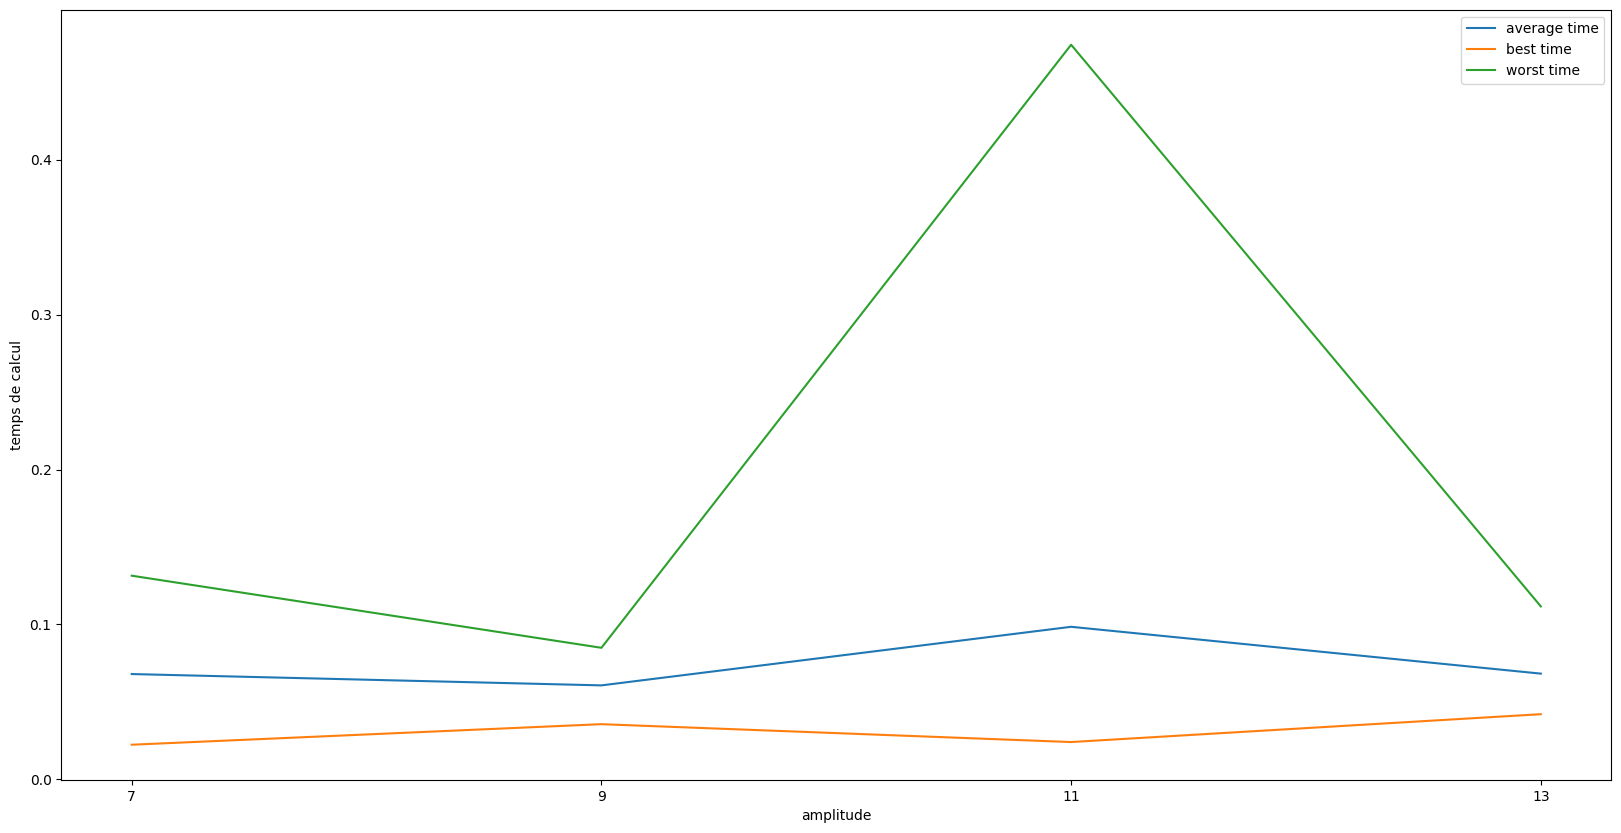

In [225]:
run_test_amplitude(10,7,15,2, 10)

In [247]:
def run_test_offset(n, offset_min, offset_max,offset_step, iterations):
    average_times =[]
    worst_times = []
    best_times = []
    

    nb_tests = ((offset_max	- offset_min) / offset_step) * iterations
    bar = IntProgress(min=0, max=nb_tests, layout={"width" : "100%"})
    display(bar)       
    for off in range(offset_min, offset_max,offset_step):
            best_time = float('inf')
            worst_time = 0
            average_time = 0
            offset = off/10
            for i in range(iterations): 
                print(f"\nRunning test with offset: {offset}")
            
                start = time.time()
                run_test(n, 0.7, offset, 0.5, 10, 10, 1.0, 2.0, 0.5, 100)
                stop = time.time()
    
                tps = stop - start
                if(tps > worst_time):
                    worst_time = tps
    
                if(tps < best_time):
                    best_time = tps
    
                average_time += tps
                
                bar.value += 1 # on met à jour la barre de progression
        
        # on met à jour les listes des temps d'exécution
            average_times.append(average_time/iterations)
            best_times.append(best_time)
            worst_times.append(worst_time)

    # on cache la barre de progression
    bar.close()
    
    # on règle l'affichage des courbes
    offsets = [x for x in range(offset_min, offset_max, offset_step)]
    plt.figure(figsize=(20,10))
    
    plt.xlabel('offset')
    plt.xticks(ticks=offsets) # valeurs affichées sur l'axe X
    plt.ylabel('temps de calcul')
    
    # on charge les données
    plt.plot(offsets, average_times,   label='average time')
    plt.plot(offsets, best_times, label='best time')
    plt.plot(offsets, worst_times,  label='worst time')
    
    # on affiche
    plt.legend()
    plt.show()

IntProgress(value=0, layout=Layout(width='100%'), max=80)


Running test with offset: 0.7
Cost of best path: 141.6212
Time taken: 0.07937359809875488 seconds

Running test with offset: 0.7
Cost of best path: 189.28720000000004
Time taken: 0.06929969787597656 seconds

Running test with offset: 0.7
Cost of best path: 193.88190000000003
Time taken: 0.16121196746826172 seconds

Running test with offset: 0.7
Cost of best path: 253.87820000000002
Time taken: 0.06622910499572754 seconds

Running test with offset: 0.7
Cost of best path: 180.67489999999995
Time taken: 0.04404950141906738 seconds

Running test with offset: 0.7
Cost of best path: 274.7985
Time taken: 0.03167009353637695 seconds

Running test with offset: 0.7
Cost of best path: 138.7403
Time taken: 0.02857494354248047 seconds

Running test with offset: 0.7
Cost of best path: 204.3721
Time taken: 0.04920697212219238 seconds

Running test with offset: 0.7
Cost of best path: 175.5112
Time taken: 0.0979146957397461 seconds

Running test with offset: 0.7
Cost of best path: 186.14190000000002
T

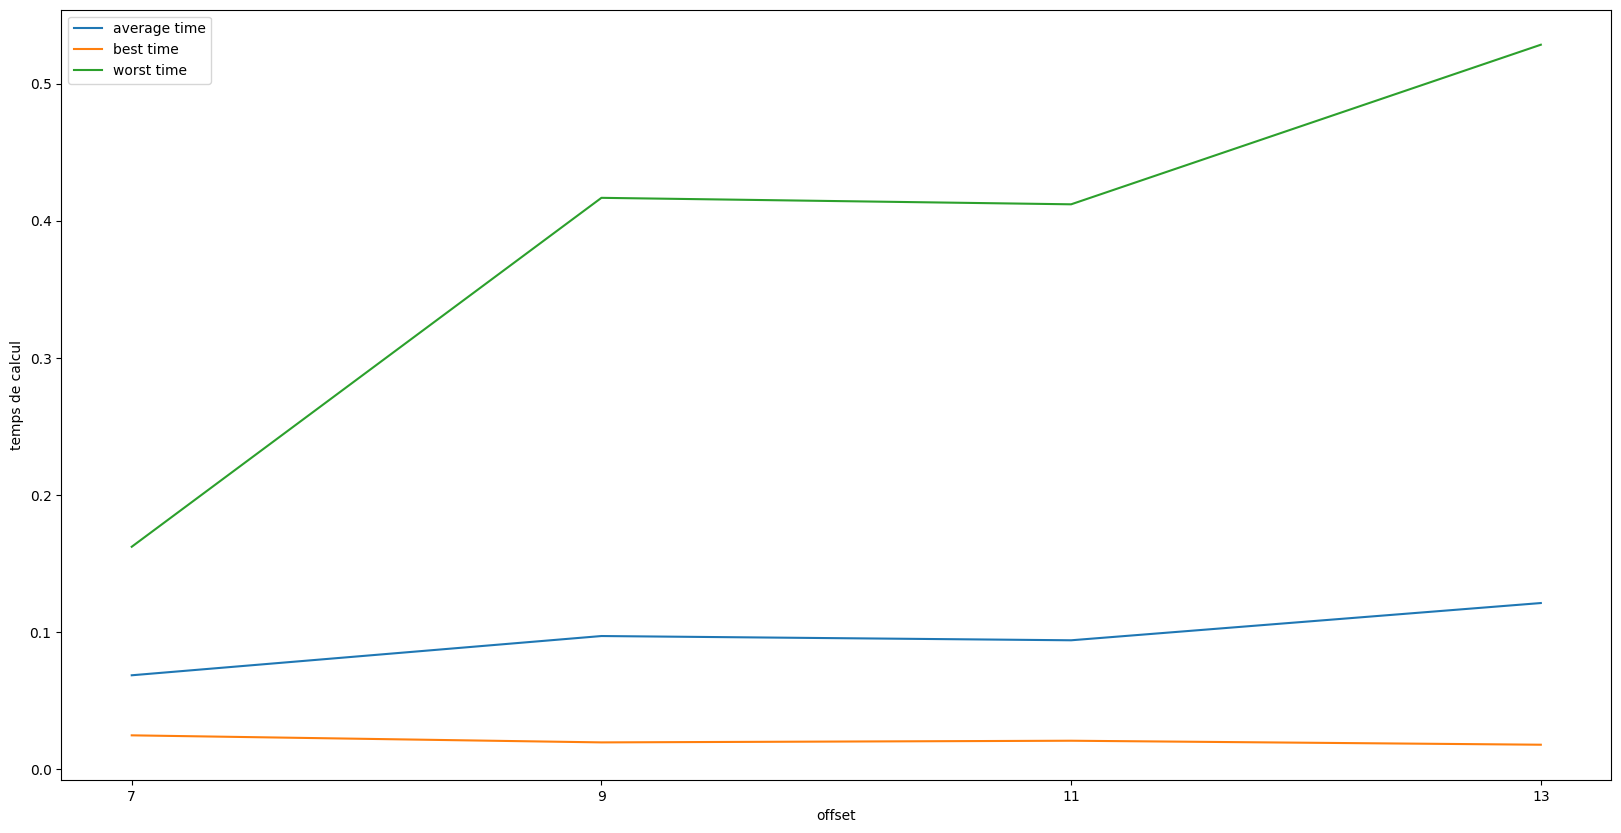

In [248]:
run_test_offset(10,7,15,2, 20)

In [245]:
def run_test_frequency(n,frequency_min, frequency_max,frequency_step, iterations):    
       
    average_times =[]
    worst_times = []
    best_times = []

    nb_tests = ((frequency_max	- frequency_min) / frequency_step) * iterations
    bar = IntProgress(min=0, max=nb_tests, layout={"width" : "100%"})
    display(bar)       
    for freq in range(frequency_min, frequency_max,frequency_step):
            best_time = float('inf')
            worst_time = 0
            average_time = 0
            frequencies = freq/10
            for i in range(iterations): 
                print(f"\nRunning test with frequency: {frequency}")
                start = time.time()
                run_test(n, 0.7, 0.3, frequency, 10, 10, 1.0, 2.0, 0.5, 100)
                stop = time.time()
    
                tps = stop - start
                if(tps > worst_time):
                    worst_time = tps
    
                if(tps < best_time):
                    best_time = tps
    
                average_time += tps
                
                bar.value += 1 # on met à jour la barre de progression
        
        # on met à jour les listes des temps d'exécution
            average_times.append(average_time/iterations)
            best_times.append(best_time)
            worst_times.append(worst_time)

    # on cache la barre de progression
    bar.close()
    
    # on règle l'affichage des courbes
    frequencies = [x for x in range(frequency_min, frequency_max, frequency_step)]
    plt.figure(figsize=(20,10))
    
    plt.xlabel('frequency')
    plt.xticks(ticks=frequencies) # valeurs affichées sur l'axe X
    plt.ylabel('temps de calcul')
    
    # on charge les données
    plt.plot(frequencies, average_times, label='average time')
    plt.plot(frequencies, best_times, label='best time')
    plt.plot(frequencies, worst_times,  label='worst time')
    
    # on affiche
    plt.legend()
    plt.show()

IntProgress(value=0, layout=Layout(width='100%'), max=40)


Running test with frequency: 0.5
Cost of best path: 88.9065
Time taken: 0.08689308166503906 seconds

Running test with frequency: 0.5
Cost of best path: 78.23570000000001
Time taken: 0.06997132301330566 seconds

Running test with frequency: 0.5
Cost of best path: 195.2703
Time taken: 0.09851264953613281 seconds

Running test with frequency: 0.5
Cost of best path: 134.8823
Time taken: 0.038754940032958984 seconds

Running test with frequency: 0.5
Cost of best path: 23.8197
Time taken: 0.08526778221130371 seconds

Running test with frequency: 0.5
Cost of best path: 49.6357
Time taken: 0.01956486701965332 seconds

Running test with frequency: 0.5
Cost of best path: 101.3701
Time taken: 0.07886075973510742 seconds

Running test with frequency: 0.5
Cost of best path: 61.373599999999996
Time taken: 0.049442291259765625 seconds

Running test with frequency: 0.5
Cost of best path: 91.0538
Time taken: 0.0755460262298584 seconds

Running test with frequency: 0.5
Cost of best path: 66.2984
Time 

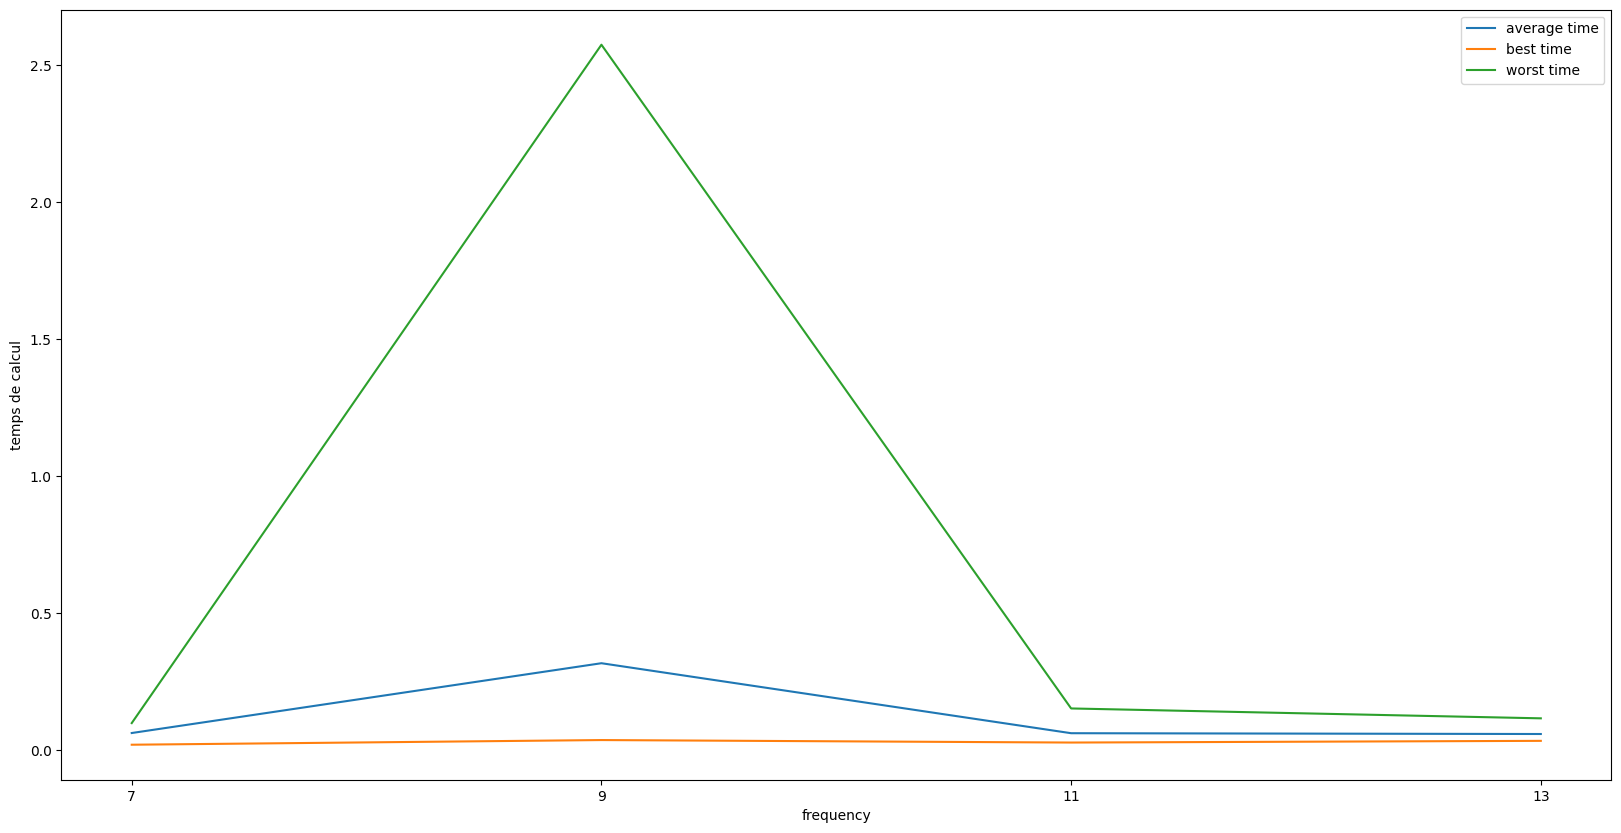

In [246]:
run_test_frequency(10, 7,15,2, 10)

In [269]:
def run_test_alpha(n, alpha_min, alpha_max, alpha_step, iterations):    
    average_times =[]
    worst_times = []
    best_times = []

    nb_tests = ((alpha_max	- alpha_min) / alpha_step) * iterations
    bar = IntProgress(min=0, max=nb_tests, layout={"width" : "100%"})
    display(bar)       
    for al in range(alpha_min, alpha_max,alpha_step):
            best_time = float('inf')
            worst_time = 0
            average_time = 0
            alpha = al/10
            for i in range(iterations): 
                print(f"\nRunning test with alpha: {alpha}")
                start = time.time()
                run_test(n, 0.7, 0.3, 0.5, 10, 10, alpha, 2.0, 0.5, 100)
                stop = time.time()
    
                tps = stop - start
                if(tps > worst_time):
                    worst_time = tps
    
                if(tps < best_time):
                    best_time = tps
    
                average_time += tps
                
                bar.value += 1 # on met à jour la barre de progression
        
        # on met à jour les listes des temps d'exécution
            average_times.append(average_time/iterations)
            best_times.append(best_time)
            worst_times.append(worst_time)

    # on cache la barre de progression
    bar.close()
    
    # on règle l'affichage des courbes
    alphas = [x for x in range(alpha_min, alpha_max, alpha_step)]
    plt.figure(figsize=(20,10))
    
    plt.xlabel('alpha')
    plt.xticks(ticks=alphas) # valeurs affichées sur l'axe X
    plt.ylabel('temps de calcul')
    
    # on charge les données
    plt.plot(alphas, average_times, label='average time')
    plt.plot(alphas, best_times, label='best time')
    plt.plot(alphas, worst_times,  label='worst time')
    
    # on affiche
    plt.legend()
    plt.show()

IntProgress(value=0, layout=Layout(width='100%'), max=20)


Running test with alpha: 1.0
Cost of best path: 125.0887
Time taken: 0.10766315460205078 seconds

Running test with alpha: 1.0
Cost of best path: 164.01160000000002
Time taken: 0.08810544013977051 seconds

Running test with alpha: 1.0
Cost of best path: inf
Time taken: 0.28641557693481445 seconds

Running test with alpha: 1.0
Cost of best path: 51.755399999999995
Time taken: 0.047026634216308594 seconds

Running test with alpha: 1.0
Cost of best path: 132.4339
Time taken: 0.03636431694030762 seconds

Running test with alpha: 1.0
Cost of best path: 133.69009999999997
Time taken: 0.06156659126281738 seconds

Running test with alpha: 1.0
Cost of best path: 87.4491
Time taken: 0.0784444808959961 seconds

Running test with alpha: 1.0
Cost of best path: inf
Time taken: 0.07847905158996582 seconds

Running test with alpha: 1.0
Cost of best path: 151.5941
Time taken: 0.03788352012634277 seconds

Running test with alpha: 1.0
Cost of best path: 118.15180000000002
Time taken: 0.04579329490661621

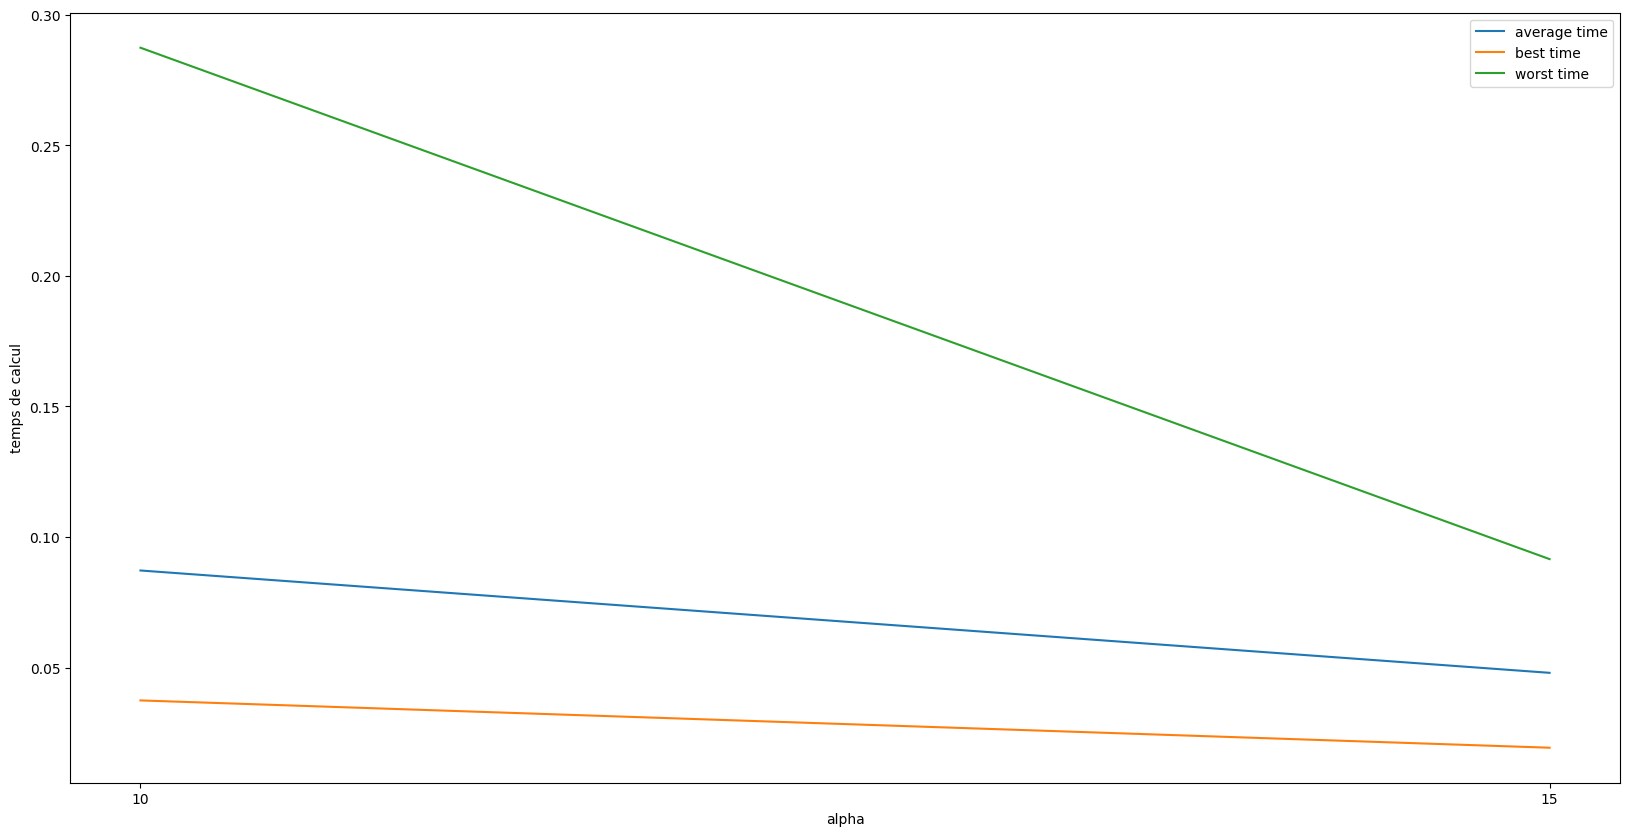

In [270]:
run_test_alpha(10, 10,20,5,10)

In [271]:
def run_test_beta(n,beta_min, beta_max, beta_step, iterations):
    average_times =[]
    worst_times = []
    best_times = []

    nb_tests = ((beta_max	- beta_min) / beta_step) * iterations
    bar = IntProgress(min=0, max=nb_tests, layout={"width" : "100%"})
    display(bar)       
    for bet in range(beta_min, beta_max,beta_step):
            best_time = float('inf')
            worst_time = 0
            average_time = 0
            beta = bet/10
            for i in range(iterations): 
                print(f"\nRunning test with beta: {beta}")
                start = time.time()
                run_test(n, 0.7, 0.3, 0.5, 10, 10, 1.0, beta, 0.5, 100)
                stop = time.time()
    
                tps = stop - start
                if(tps > worst_time):
                    worst_time = tps
    
                if(tps < best_time):
                    best_time = tps
    
                average_time += tps
                
                bar.value += 1 # on met à jour la barre de progression
        
        # on met à jour les listes des temps d'exécution
            average_times.append(average_time/iterations)
            best_times.append(best_time)
            worst_times.append(worst_time)

    # on cache la barre de progression
    bar.close()
    
    # on règle l'affichage des courbes
    betas = [x for x in range(beta_min, beta_max, beta_step)]
    plt.figure(figsize=(20,10))
    
    plt.xlabel('beta')
    plt.xticks(ticks=betas) # valeurs affichées sur l'axe X
    plt.ylabel('temps de calcul')
    
    # on charge les données
    plt.plot(betas, average_times, label='average time')
    plt.plot(betas, best_times, label='best time')
    plt.plot(betas, worst_times,  label='worst time')
    
    # on affiche
    plt.legend()
    plt.show()

IntProgress(value=0, layout=Layout(width='100%'), max=20)


Running test with beta: 2.0
Cost of best path: 56.4056
Time taken: 0.06362700462341309 seconds

Running test with beta: 2.0
Cost of best path: inf
Time taken: 0.05388975143432617 seconds

Running test with beta: 2.0
Cost of best path: 89.088
Time taken: 0.12399172782897949 seconds

Running test with beta: 2.0
Cost of best path: 87.88050000000001
Time taken: 0.0623779296875 seconds

Running test with beta: 2.0
Cost of best path: 53.177
Time taken: 0.07500052452087402 seconds

Running test with beta: 2.0
Cost of best path: 72.3255
Time taken: 0.055871009826660156 seconds

Running test with beta: 2.0
Cost of best path: 167.02810000000002
Time taken: 0.09710431098937988 seconds

Running test with beta: 2.0
Cost of best path: 94.49889999999999
Time taken: 0.0852208137512207 seconds

Running test with beta: 2.0
Cost of best path: 75.1434
Time taken: 0.053225040435791016 seconds

Running test with beta: 2.0
Cost of best path: 84.45479999999999
Time taken: 0.1252305507659912 seconds

Running 

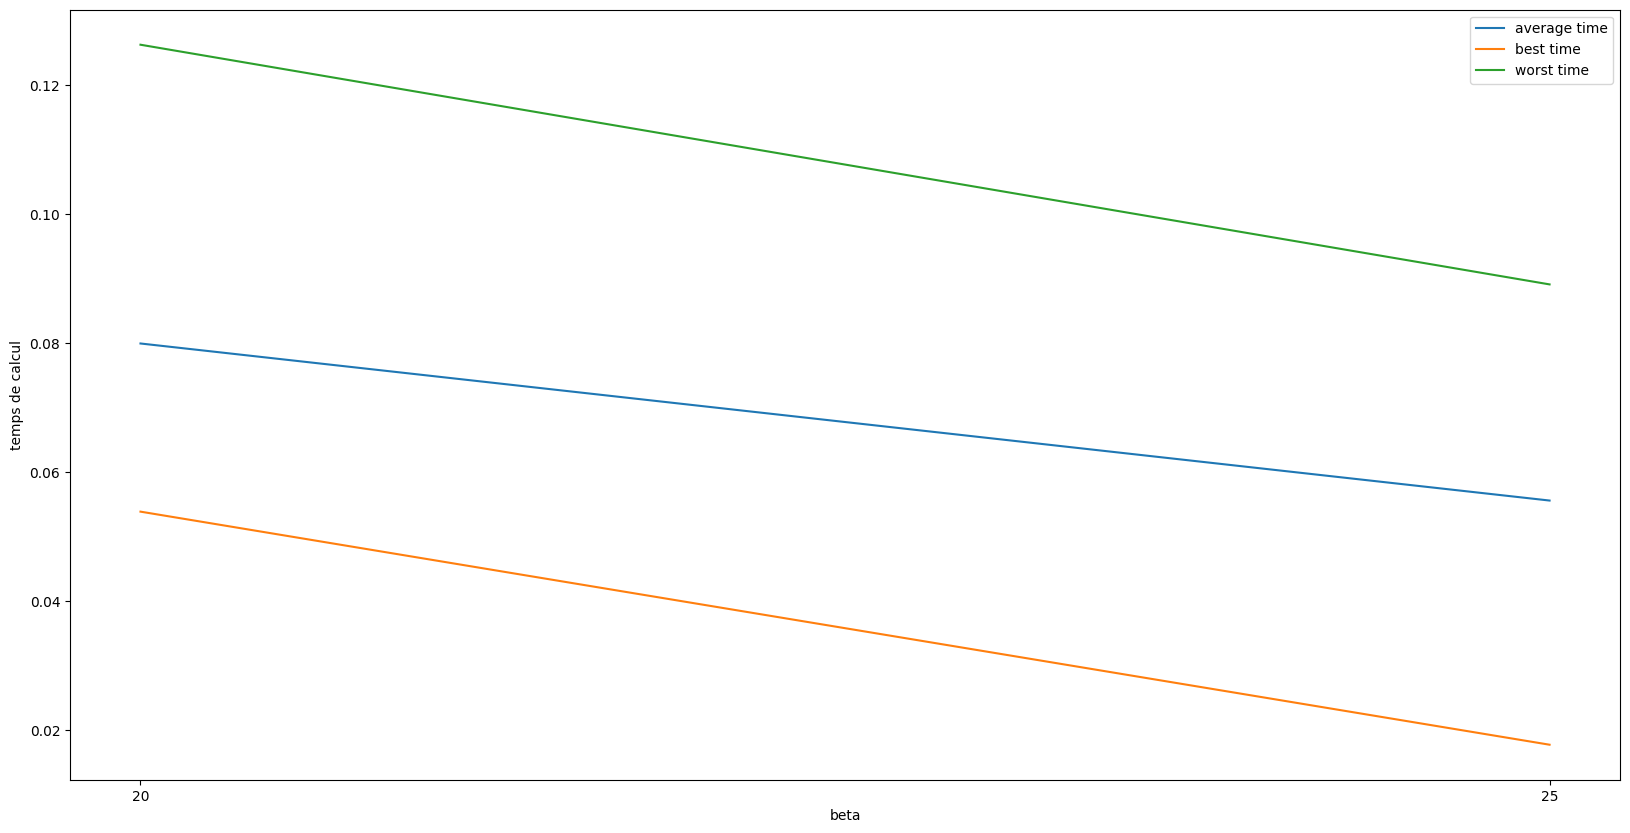

In [272]:
run_test_beta(10,20,30,5,10)

In [286]:
def run_test_rho(n,roh_min, roh_max, roh_step, iterations):
    average_times =[]
    worst_times = []
    best_times = []

    nb_tests = ((roh_max	- roh_min) / roh_step) * iterations
    bar = IntProgress(min=0, max=nb_tests, layout={"width" : "100%"})
    display(bar)       
    for rh in range(roh_min, roh_max,roh_step):
            best_time = float('inf')
            worst_time = 0
            average_time = 0
            roh = rh/10
            for i in range(iterations): 
                print(f"\nRunning test with rho: {roh}")
                start = time.time()
                run_test(n, 0.7, 0.3, 0.5, 10, 10, 1.0, 2.0, roh, 100)

                stop = time.time()
    
                tps = stop - start
                if(tps > worst_time):
                    worst_time = tps
    
                if(tps < best_time):
                    best_time = tps
    
                average_time += tps
                
                bar.value += 1 # on met à jour la barre de progression
        
        # on met à jour les listes des temps d'exécution
            average_times.append(average_time/iterations)
            best_times.append(best_time)
            worst_times.append(worst_time)

    # on cache la barre de progression
    bar.close()
    
    # on règle l'affichage des courbes
    rohs = [x for x in range(roh_min, roh_max, roh_step)]
    plt.figure(figsize=(20,10))
    
    plt.xlabel('rohs')
    plt.xticks(ticks=rohs) # valeurs affichées sur l'axe X
    plt.ylabel('temps de calcul')
    
    # on charge les données
    plt.plot(rohs, average_times, label='average time')
    plt.plot(rohs, best_times, label='best time')
    plt.plot(rohs, worst_times,  label='worst time')
    
    # on affiche
    plt.legend()
    plt.show()

IntProgress(value=0, layout=Layout(width='100%'), max=20)


Running test with rho: 0.5
Cost of best path: 125.04299999999999
Time taken: 0.09590578079223633 seconds

Running test with rho: 0.5
Cost of best path: 45.4846
Time taken: 0.04725337028503418 seconds

Running test with rho: 0.5
Cost of best path: inf
Time taken: 0.026596784591674805 seconds

Running test with rho: 0.5
Cost of best path: 81.66
Time taken: 0.05441880226135254 seconds

Running test with rho: 0.5
Cost of best path: 102.8066
Time taken: 0.04422903060913086 seconds

Running test with rho: 0.5
Cost of best path: 100.78150000000002
Time taken: 0.03830242156982422 seconds

Running test with rho: 0.5
Cost of best path: 89.054
Time taken: 0.03797125816345215 seconds

Running test with rho: 0.5
Cost of best path: 29.328500000000002
Time taken: 0.05980563163757324 seconds

Running test with rho: 0.5
Cost of best path: inf
Time taken: 0.05974721908569336 seconds

Running test with rho: 0.5
Cost of best path: 105.87180000000001
Time taken: 0.045192718505859375 seconds

Running test 

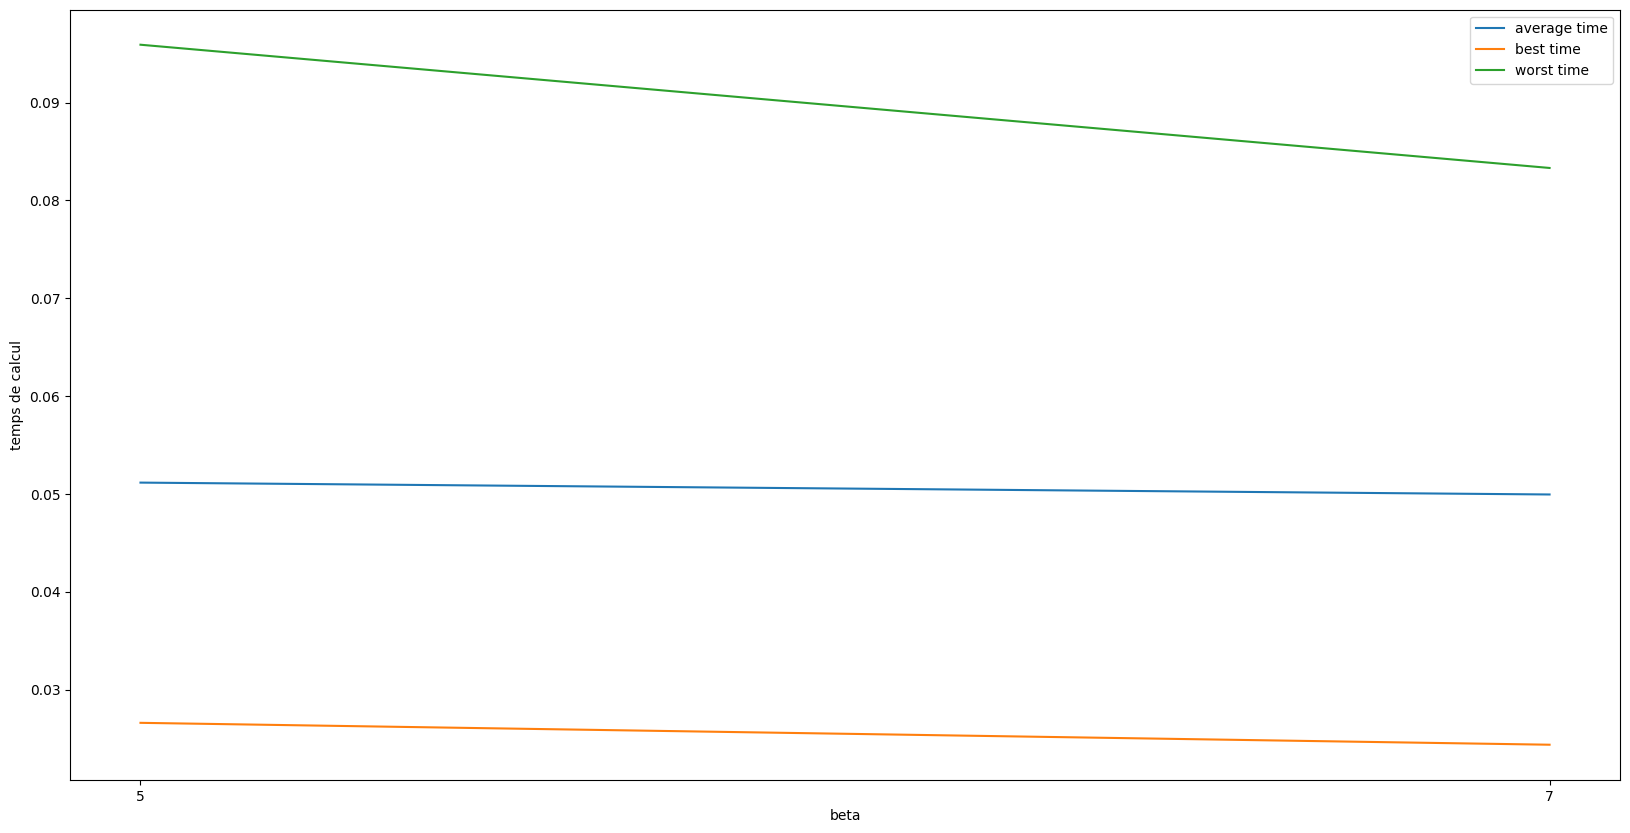

In [287]:
run_test_rho(10, 5,9,2,10)

In [288]:
def run_test_q(n,q_min, q_max, q_step, iterations):
    average_times =[]
    worst_times = []
    best_times = []

    nb_tests = ((q_max	- q_min) / q_step) * iterations
    bar = IntProgress(min=0, max=nb_tests, layout={"width" : "100%"})
    display(bar)       
    for qq in range(q_min, q_max,q_step):
            best_time = float('inf')
            worst_time = 0
            average_time = 0
            q = qq/10
            for i in range(iterations): 
                print(f"\nRunning test with q: {q}")
                start = time.time()
                run_test(n, 0.7, 0.3, 0.5, 10, 10, 1.0, 2.0, 0.5, q)

                stop = time.time()
    
                tps = stop - start
                if(tps > worst_time):
                    worst_time = tps
    
                if(tps < best_time):
                    best_time = tps
    
                average_time += tps
                
                bar.value += 1 # on met à jour la barre de progression
        
        # on met à jour les listes des temps d'exécution
            average_times.append(average_time/iterations)
            best_times.append(best_time)
            worst_times.append(worst_time)

    # on cache la barre de progression
    bar.close()
    
    # on règle l'affichage des courbes
    qs = [x for x in range(q_min, q_max, q_step)]
    plt.figure(figsize=(20,10))
    
    plt.xlabel('q')
    plt.xticks(ticks=qs) # valeurs affichées sur l'axe X
    plt.ylabel('temps de calcul')
    
    # on charge les données
    plt.plot(qs, average_times, label='average time')
    plt.plot(qs, best_times, label='best time')
    plt.plot(qs, worst_times,  label='worst time')
    
    # on affiche
    plt.legend()
    plt.show()

IntProgress(value=0, layout=Layout(width='100%'), max=200)


Running test with q: 100.0
Cost of best path: 111.40629999999999
Time taken: 0.10885143280029297 seconds

Running test with q: 100.0
Cost of best path: 75.1036
Time taken: 0.0533757209777832 seconds

Running test with q: 100.0
Cost of best path: 62.0831
Time taken: 0.2668001651763916 seconds

Running test with q: 100.0
Cost of best path: 226.17439999999996
Time taken: 0.09112000465393066 seconds

Running test with q: 100.0
Cost of best path: inf
Time taken: 0.0736379623413086 seconds

Running test with q: 100.0
Cost of best path: 62.1264
Time taken: 0.05351686477661133 seconds

Running test with q: 100.0
Cost of best path: inf
Time taken: 0.06274795532226562 seconds

Running test with q: 100.0
Cost of best path: 118.64840000000001
Time taken: 0.028680801391601562 seconds

Running test with q: 100.0
Cost of best path: 205.40509999999998
Time taken: 0.07044649124145508 seconds

Running test with q: 100.0
Cost of best path: 142.94670000000002
Time taken: 0.06808280944824219 seconds

Runn

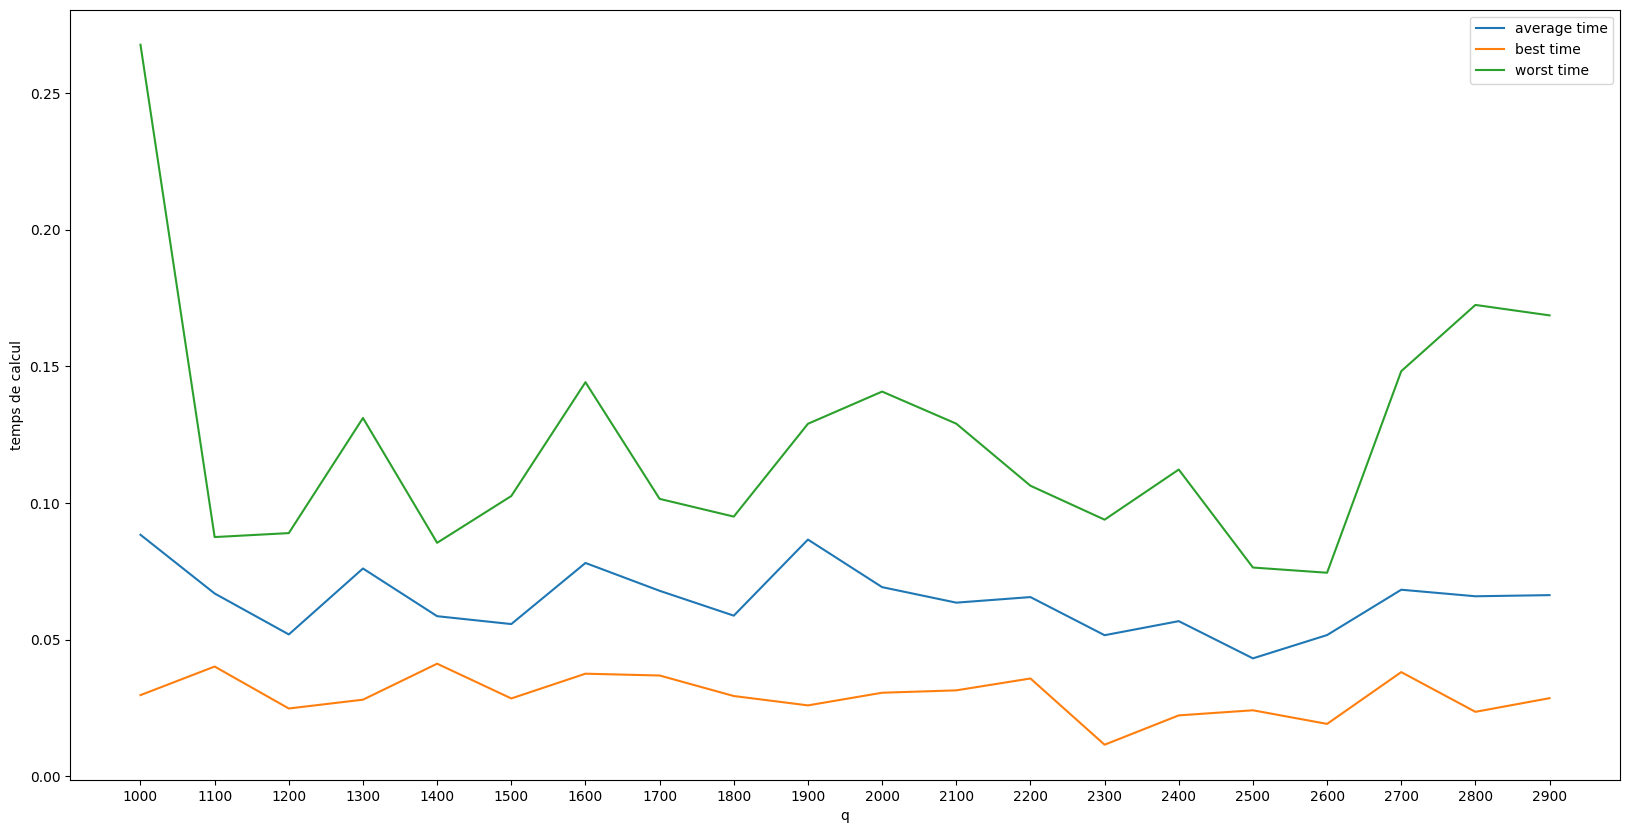

In [290]:
run_test_q(10, 1000,3000, 100,10)

 # Paramètre n
Description: Ce paramètre détermine le nombre de villes (nœuds) dans le graphe.
Impact:
Taille du graphe: Plus n est grand, plus le graphe est grand, ce qui augmente la complexité du problème.
Nombre de chemins possibles: Une augmentation de n entraîne une augmentation exponentielle du nombre de chemins possibles, rendant le problème plus difficile à résoudre.
Performance: Une plus grande valeur de n nécessite plus de temps de calcul et de mémoire pour explorer les chemins et trouver le meilleur chemin.

# Paramètre amplitude
Description: Ce paramètre contrôle l'amplitude des variations sinusoïdales dans la fonction de coût dynamique C.
Impact:
Variabilité du coût: Une plus grande amplitude signifie que les coûts peuvent varier de manière plus significative en fonction du temps, rendant le problème plus complexe.
Difficulté à prévoir les coûts: Avec une plus grande amplitude, il est plus difficile de prévoir les coûts futurs, ce qui peut compliquer la recherche du chemin optimal.

# Paramètre offset
Description: Ce paramètre contrôle la valeur de décalage dans la fonction de coût dynamique C.
Impact:
Niveau de base du coût: Un offset plus élevé augmente les valeurs de base du coût, rendant tous les trajets plus coûteux.
Difficulté relative des chemins: En ajustant le niveau de base des coûts, ce paramètre peut influencer la difficulté relative de différents chemins, affectant ainsi les décisions prises par l'algorithme.

# Paramètre frequency
Description: Ce paramètre contrôle la fréquence des oscillations dans la fonction de coût dynamique C.
Impact:
Changement rapide des coûts: Une fréquence plus élevée signifie que les coûts changent plus rapidement en fonction du temps, rendant la dynamique des coûts plus volatile.
Complexité temporelle: Des fréquences plus élevées introduisent plus de variations temporelles, ce qui peut compliquer la recherche du chemin optimal car les coûts changent rapidement avec le temps.

# phi : Paramètre de modulation 
Influence : Ce paramètre peut influencer la fonction de coût utilisée pour évaluer les solutions. Une valeur appropriée de phi peut aider à équilibrer différents facteurs dans le coût.


# Temp : 
Influence : c'est une valeur pseudo-aléatoire fixe pour chaque paire de sommets, générée une fois et utilisée pour introduire de l'aléatoire sans perdre la continuité temporelle.


# Nombre de fourmis :

Influence : Plus il y a de fourmis, plus l'exploration de l'espace de recherche est exhaustive. Cela peut améliorer la qualité des solutions trouvées, mais augmente également le temps de calcul.


# Nombre d'itérations :

Influence : Plus le nombre d'itérations est élevé, plus l'algorithme a de chances de trouver une solution optimale, mais cela augmente aussi le temps de calcul.

# Alpha :
Influence : Plus la valeur de alpha est élevée, plus les fourmis sont attirées par les chemins avec des niveaux élevés de phéromones. Cela favorise l'exploitation des chemins connus.



## Beta :
Influence : Plus la valeur de beta est élevée, plus les fourmis sont attirées par les chemins les plus courts ou moins coûteux. Cela favorise l'exploration des chemins plus prometteurs.




# Rho :
Influence : Plus le taux d'évaporation est élevé, plus les phéromones se dissipent rapidement, ce qui empêche les solutions anciennes de dominer trop longtemps. Cela favorise l'exploration de nouvelles solutions.



# Q :

Influence : Plus la quantité de phéromones déposée est élevée, plus l'influence d'une fourmi sur le chemin choisi est grande. Cela peut accélérer la convergence vers une solution, mais augmente aussi le risque de convergence prématurée.



# Conclusion et Recommandations pour l'Amélioration des Performances de l'Algorithme

## Analyse des Paramètres et de leur Impact
Au cours de cette étude expérimentale, nous avons analysé l'impact de divers paramètres sur les performances de notre algorithme de colonie de fourmis (ACO) appliqué à un problème de collecte et de livraison. Les paramètres testés incluent le nombre de villes, les paramètres du coût dynamique (amplitude, offset, fréquence), et les paramètres de l'ACO (nombre de fourmis, nombre d'itérations, alpha, beta, rho, q). Voici les conclusions principales et les recommandations pour améliorer le coût, le chemin trouvé et le temps d'exécution :

Pour obtenir les meilleures performances en termes de coût, de qualité du chemin et de temps d'exécution, il est crucial de trouver un équilibre entre les différents paramètres de l'algorithme : 

- Pour un meilleur coût et chemin : il faut augmenter le nombre d'itérations et ajuster alpha et beta pour équilibrer l'exploration et l'exploitation, ajuster des coûts dynamiques via les paramètres d'amplitude, offset et fréquence est également essentielle. pour les paramètres de l'ACO il faut, Alpha (1.0-1.5) : Augmenter alpha pour renforcer l'influence des phéromones et encourager l'exploitation, ou diminuer alpha pour favoriser l'exploration. 
Beta (2.0-3.0) : Augmenter beta pour renforcer l'influence de l'heuristique et encourager l'exploration de nouveaux chemins, ou diminuer beta pour réduire cette influence.
Pour les parametres comme l'amplitude, offset et la fréquencenous vous conseillons, une amplitude entre 0.7 et 1.0 permet de créer suffisamment de variations pour favoriser l'exploration sans rendre l'algorithme trop instable, un offset dans entre 0.3 -0.5 stabilise les coûts de base, évitant les chemins non représentatifs et permettant une meilleure comparaison des chemins et une fréquence entre 0.5 et 1.0 permet de modéliser des fluctuations réalistes sans introduire de variations trop rapides ou trop lentes.

 - Pour un temps d'exécution réduit : Limiter le nombre de fourmis et d'itérations à des valeurs modérées tout en maintenant des taux d'évaporation et des quantités de phéromones appropriées pour éviter une convergence trop lente ou une stagnation. Nous vous conseillons d'utiliser un taux d'évaporation modéré (0.5-0.7) pour maintenir un bon équilibre entre l'exploration et l'exploitation. Augmenter rho pour favoriser l'exploration, ou diminuer rho pour renforcer l'influence des phéromones mais aussi d'utiliser une valeur modérée de q (100-200) semble optimale pour favoriser la convergence sans causer de stagnation. Augmenter q pour encourager la convergence, ou diminuer q pour éviter la stagnation prématurée.
